# **TelecomX Challenge – Parte 2**
Notebook desarrollado para el análisis de datos, preprocesamiento y modelado predictivo.

Este documento incluye:
- Exploración inicial de datos (EDA)
- Limpieza y preprocesamiento
- Codificación de variables categóricas
- Entrenamiento de modelos de Machine Learning
- Evaluación y métricas
- Interpretabilidad de modelos
- Exportación de resultados y modelos

**Autor:** Magno Gabriel Huaromo Montañez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import VarianceThreshold
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')

 # **Preparación de los Datos🛠️**

## **1. Extracción del Archivo Tratado**

In [3]:
PATH = 'https://raw.githubusercontent.com/DevMagnov/Challenge_TelecomX_2_M-Huaromo/refs/heads/main/datos_challenge.csv'  
df = pd.read_csv(PATH)
print('Dimensiones:', df.shape)
df.head()

Dimensiones: (7267, 21)


,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## **2. Exploración inicial de datos (EDA)**

In [4]:
# Información general
df.info()

# Resumen estadístico de variables numéricas
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7043 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


,SeniorCitizen,tenure,Charges.Monthly
count,7267.000000,7267.000000,7267.000000
mean,0.162653,32.346498,64.720098
std,0.369074,24.571773,30.129572
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.425000
50%,0.000000,29.000000,70.300000
75%,0.000000,55.000000,89.875000
max,1.000000,72.000000,118.750000


In [ ]:
# Distribución de valores nulos
df.isnull().sum().sort_values(ascending=False)

## **3. Identificación de la variable objetivo (target)**

In [5]:
possible_targets = [c for c in df.columns if c.lower() in ['churn','cancel','cancelled','canceled']]
if not possible_targets:
    raise ValueError('No se detectó columna target')
target_col = possible_targets[0]
print('Variable target:', target_col)
df[target_col].value_counts(normalize=True)

Variable target: Churn


Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## **4. Limpieza y preprocesamiento**

In [6]:
# Eliminar IDs irrelevantes
id_candidates = [c for c in df.columns if c.lower() in ['customerid','id','clientid','clienteid','custid']]
if id_candidates:
    df.drop(columns=id_candidates, inplace=True)

# Manejo de valores nulos
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != target_col]
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for c in num_cols:
    if df[c].isnull().any():
        df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    if df[c].isnull().any():
        df[c].fillna('Unknown', inplace=True)

# Mapear target a 0/1
mapping = {}
for val in df[target_col].unique():
    if str(val).strip().lower() in ['yes','si','true','1','churn']:
        mapping[val] = 1
    else:
        mapping[val] = 0
df[target_col] = df[target_col].map(mapping).astype(int)
df.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,1,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,1,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,1,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## **5. Reducción de categorías raras**

In [7]:
threshold = 0.01
for c in cat_cols:
    vc = df[c].value_counts(normalize=True)
    rares = vc[vc < threshold].index.tolist()
    if rares:
        df[c] = df[c].apply(lambda x: 'Other' if x in rares else x)

## **6. Codificación One-Hot**

In [8]:
X = df.drop(columns=[target_col])
y = df[target_col]
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
print('Dimensiones después del encoding:', X_encoded.shape)

Dimensiones después del encoding: (7267, 29)


In [9]:
selector = VarianceThreshold(threshold=0.0001)
selector.fit(X_encoded)
mask = selector.get_support()
X_sel = X_encoded.loc[:, mask]
print('Dimensiones después de eliminar variables constantes:', X_sel.shape)

Dimensiones después de eliminar variables constantes: (7267, 29)


## **7. División de datos en entrenamiento y prueba**

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, random_state=42, stratify=y)
print('Tamaño de entrenamiento:', X_train.shape)
print('Tamaño de prueba:', X_test.shape)

Tamaño de entrenamiento: (5086, 29)
Tamaño de prueba: (2181, 29)


## **8. Entrenamiento de modelos**

In [11]:
# Escalado para regresión logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced')

log_reg.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## **9. Evaluación de modelos**

In [12]:
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)

print('--- Logistic Regression ---')
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

print('--- Random Forest ---')
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

--- Logistic Regression ---
[[1174  446]
 [ 117  444]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.81      1620
           1       0.50      0.79      0.61       561

    accuracy                           0.74      2181
   macro avg       0.70      0.76      0.71      2181
weighted avg       0.80      0.74      0.76      2181

--- Random Forest ---
[[1437  183]
 [ 307  254]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1620
           1       0.58      0.45      0.51       561

    accuracy                           0.78      2181
   macro avg       0.70      0.67      0.68      2181
weighted avg       0.76      0.78      0.77      2181



## **10. Interpretación de modelos**

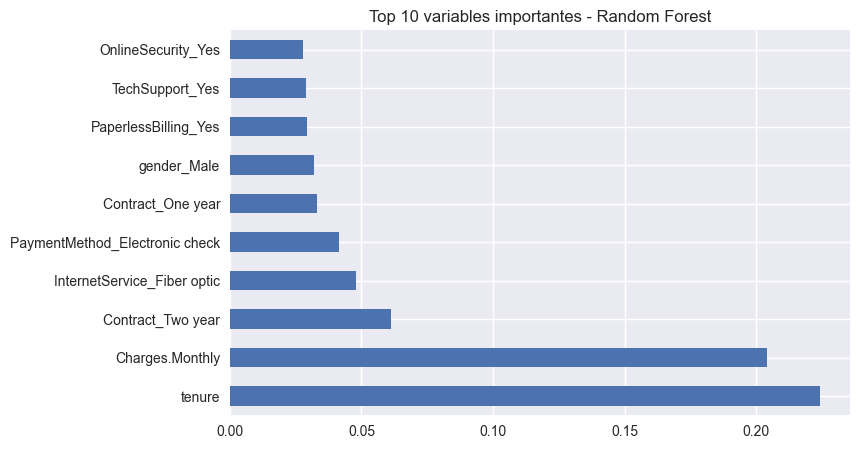

In [13]:
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
rf_importances.head(10).plot(kind='barh', figsize=(8,5))
plt.title('Top 10 variables importantes - Random Forest')
plt.show()